Enter names of students working in a team of two here: [Firstname Surname] [Firstname Surname]

# XCT Exercise 1 - X-Ray Projections and Digital Subtraction Angiography

The purpose of the exercise is to understand and study X-ray planar projection imaging and digital subtraction angiography. 
To this end, an analytical computer model of the human thorax (=analytical phantom) is implemented using circles/ellipses 
assigned with realistic tissue densities and mass attenuation coefficients. Line integrals will be computed to obtain X-ray projection data. 

## Imports

Necessary imports:

In [56]:
!pip install pint -qq
from copy import deepcopy

import numpy as np
from pint import Quantity
import matplotlib.pyplot as plt

%matplotlib inline

Default constants:

In [57]:
# Define image matrix
matrix = (256, 256)

# Used for plotting:
matrix_extent = (-np.fix(matrix[0]/2), np.fix(matrix[0]/2), -np.fix(matrix[0]/2), np.fix(matrix[0]/2))

## Section 1 - Basic Definitions

Define an analytical phantom as a composition of ellipses with absorption coefficients corresponding to different tissue types (blood, bone, lung, muscle)!

### Define Tissue Densities and Mass Attenuation Coefficients

#### Task 1.1
> Look up the values for tissue density and mass attenuation coefficients for 50 keV and 150 keV - refer to www.nist.gov/pml/data/xraycoef/

In [58]:
# TASK: Fill in below
tissue_densities = dict(
    blood=Quantity( 1.060, "g/cm**3"),
    bone=Quantity( 1.920, "g/cm**3"),
    lung=Quantity( 0.001, "g/cm**3"),
    muscle=Quantity( 1.050, "g/cm**3"),
)

# TASK: Fill in below
mass_attenuation_coeffs_50keV = dict(
    blood=Quantity( 0.2278, "cm**2/g"),
    bone=Quantity( 0.4242, "cm**2/g"),
    lung=Quantity( 0.2080, "cm**2/g"),
    muscle=Quantity( 0.2262, "cm**2/g"),
)

# TASK: Fill in below
mass_attenuation_coeffs_150keV = dict(
    blood=Quantity( 0.1492, "cm**2/g"),
    bone=Quantity( 0.1480, "cm**2/g"),
    lung=Quantity( 0.1493 ,"cm**2/g"),
    muscle=Quantity( 0.1492, "cm**2/g"),
)

#### Task 1.2
> Calculate linear attenuation coefficients from the quantities defined above for 50 keV and 150 keV using the appropriate equation.


In [59]:
lin_attenuation_coeffs_50kev = {k: tissue_densities[k] * mass_attenuation_coeffs_50keV[k] for k in tissue_densities.keys()}
lin_attenuation_coeffs_150kev = {k: tissue_densities[k] * mass_attenuation_coeffs_150keV[k] for k in tissue_densities.keys()}

#### Task 1.3
>How do linear attenuation coefficients vary as a function of anode voltage? What are the fundamental physical effects?

*Type your answer into this cell:*

> linear attenuation coefficient decrease with increasing anode voltage.
> photoelectric effect


### Define Simple Analytical Phantom 
In the following you will define a phantom as a composition of ellipses as geometrical representation of the parts. Each ellipse is assigned a linear attenuation coefficient $\mu$ and defined using center point $x_0,y_0$, half axes $a,b$ and tilt angle $\theta$ relative to the $x$-axis (see Figure) according to the relation: 
    
$\left(\vec{x} - (x_0, y_0)^T \right)^T \mathbf{Q}^T \mathbf{D}^2 \mathbf{Q} \left(\vec{x} - (x_0, y_0)^T \right) \leq  1 
\quad with \quad   
D = \begin{bmatrix} 1/a & 0 \\ 0 & 1/b \end{bmatrix}, \quad Q = \begin{bmatrix} cos{\theta} & sin{\theta} \\ -sin{\theta} & cos{\theta} \end{bmatrix}$

![Figure 1](figure1.png)

#### Task 1.4
> The function `calculate_discrete_phantom` given below demonstrates how to use the formalism of defining ellipses. 
> Have a look at the code, fill in the empty comments and explain what the code does! 

All matrix and vector products were implemented using `np.einsum`, for more explanation see: https://numpy.org/doc/stable/reference/generated/numpy.einsum.html. Please note that there are multiple ways to do these operations in numpy such as `np.dot` and `np.matmul` (non-exhasutive list) and you can look them up in the numpy documentation for linear algebra operations: https://numpy.org/doc/stable/reference/routines.linalg.html#.

In [60]:
from typing import List, Tuple
from types import SimpleNamespace

def calculate_discrete_phantom(matrix: Tuple[int, int], phantom: List[SimpleNamespace]) -> np.ndarray:
    
    """ Calculates discretized representation of phantom 
    :param matrix:  image matrix
    :param phantom: list of SimpleNamespaces that each must contain values for (x0, y0, a, b, theta, mue)
                    to describe a single ellipse
    :image: discretized phantom 
    """
    
    # Coordinates in matrix
    xcoords, ycoords = np.meshgrid(np.arange(-np.fix(matrix[0] / 2), np.fix(matrix[0] / 2)),
                                   np.arange(-np.fix(matrix[1] / 2), np.fix(matrix[1] / 2)))
    
    # Stack matrix coordinates into vector
    phantom_coordinates = np.stack([xcoords, ycoords], axis=-1)
    
    # Placeholder image
    image = Quantity(np.zeros(matrix), "1/cm")
    
    # Loop over all ellipses defined in phantom
    for ellipse in phantom:
        
        # Get theta
        theta = np.deg2rad(ellipse.theta)

        # TASK: ???coordinates of phantom with respect to the ellipse's center
        x_ = phantom_coordinates - np.stack([ellipse.x0, ellipse.y0]).reshape(1, 1, 2)
        
        # TASK: ???Transformation matrix for scaling 
        D = np.array([[1/ellipse.a, 0], [0, 1/ellipse.b]])
        
        # TASK: ??? Rotation matrix for the ellipse 
        Q = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
        
        # TASK: ???matrix multiplication
        DQ = np.einsum("ij, jk", D, Q)
        
        # TASK: ???Calculate the value based on the transformed coordinates
        value =  np.sum(np.einsum("ij, xyj -> xyi", DQ, x_) ** 2, axis=-1)
        
        # TASK: ???Create a mask for points inside the ellipse
        mask = np.where(value < 1, np.ones_like(value), np.zeros_like(value))

        # Fill matrix points corresponding to ellipses 
        image = image + Quantity(mask, "dimensionless") * ellipse.mue
        
    return image

### Calculate Projections of Simple Phantom 
#### Task 1.5
> Use the simple phantom defined below, compute its discrete representation and calculate horizontal and vertical projections by summing along columns and rows of the image!
Vary position, size and tilt angle of the test object and recompute the projections!
Why is summing along columns/rows of the discretized phantom not representative of an actual projection? 

Write down your observations into the cell below:

*Type your answer in this cell:*
> Lose spacial information

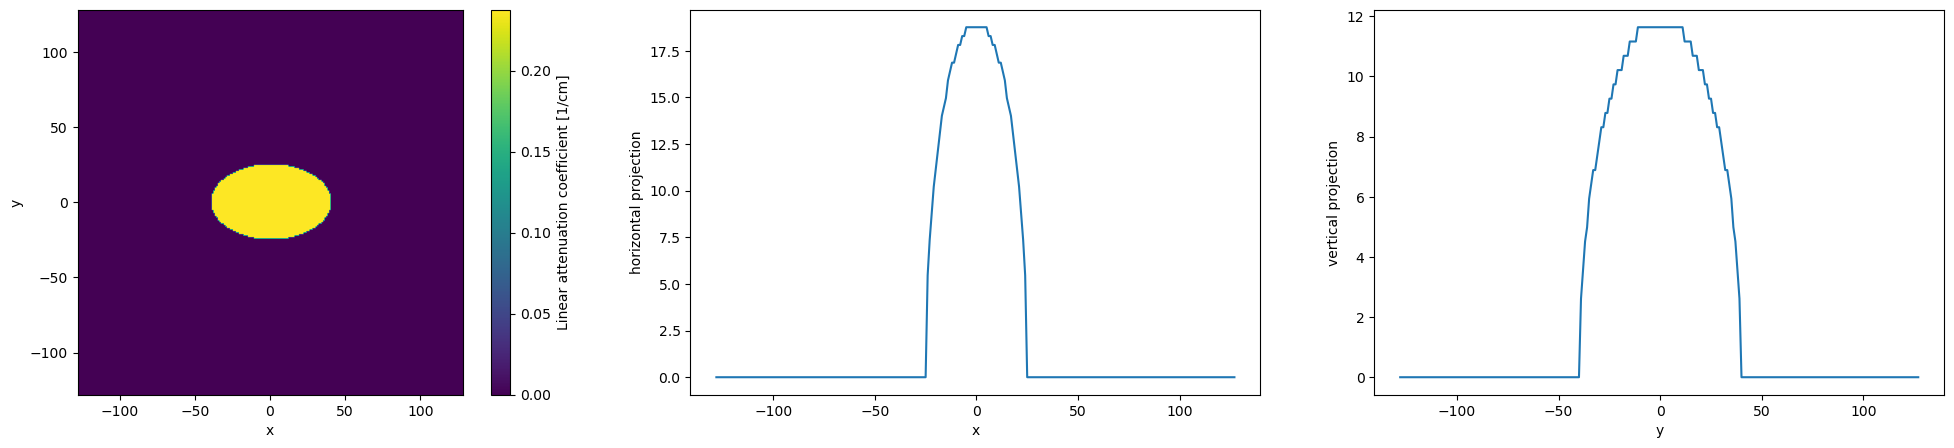

In [61]:
# Define simple phantom consisting of a single ellipse
simple_phantom = [SimpleNamespace(x0=0, y0=0, a=40, b=25, theta=0, mue=lin_attenuation_coeffs_50kev["muscle"])]

# Calculate discrete phantom
image = calculate_discrete_phantom(matrix, simple_phantom)

# Plot discretized simple phantom
plt.close("all")
fig1, axes1 = plt.subplots(1, 3, figsize=(25, 5))
artist = axes1[0].imshow(image.m_as("1/cm"), origin="lower", extent=matrix_extent)
fig1.colorbar(artist, ax=axes1[0], label="Linear attenuation coefficient [1/cm]")

# TASK: Compute horizontal and vertical projections 
projection_vert = np.sum(image, axis=0)
projection_hori = np.sum(image, axis=1)

# Plot projections
axes1[1].plot(np.arange(-np.fix(matrix[0]/2), np.fix(matrix[0]/2)), projection_hori)
axes1[2].plot(np.arange(-np.fix(matrix[0]/2), np.fix(matrix[0]/2)), projection_vert)

# Format axes
axes1[0].set_xlabel("x"), axes1[0].set_ylabel("y");
axes1[1].set_xlabel("x"), axes1[1].set_ylabel("horizontal projection");
axes1[2].set_xlabel("y"), axes1[2].set_ylabel("vertical projection");

# Section 2 - Calculate Analytical Line Integrals 
To correctly calculate projections, X-ray photons are assumed to travel along straight paths $s$ from the X-ray source to the detector (see Figure). The line $L(r, s, \phi)$ between the X-ray source and the detector, intersecting the detector plane orthogonally can be described by the following parameterization:

$ \vec{x} = (x, y)^T = r \begin{pmatrix} cos{\phi} \\ sin{\phi} \end{pmatrix} + s \begin{pmatrix} sin{\phi} \\ - cos{\phi} \end{pmatrix}$

To compute the projection of an ellipse for an arbitrary angle $\phi$ one can calculate the intersection points of the line $L(r, s, \phi)$ with the ellipse. As ellipses are convex, there can at most be one entry and one exit point. 

![Figure 2](figure2.png)

#### Task 2.1
> Edit the incomplete function `calculate_line_integral` at the marked line (see cell below) to perform the line-integration of ellipses.     
> *Hint*: How can the integration of a constant function be simplified?




In [62]:
def calculate_line_integrals(detector_bins: int, phi: np.array, phantom: List[SimpleNamespace]) -> np.ndarray:
    
    """ Calculate line integrals of a collection of ellipses by finding the intersection points of lines with ellipses 
    
    :param detector_bins: number of detector bins
    :param phi: sequence of angles in degree for which the integration is performed
    :param phantom: list of SimpleNamespaces that each contains values for (x0, y0, a, b, theta, mue)
                    to describe a single ellipsis.
    :return: projections for each angle phi (detector_bins, len(phi))
    """
    
    # Polar coordinates (r, phi) 
    r, phi_ = np.meshgrid(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)), np.deg2rad(phi))
    
    # Convert polar into Cartesian coordinates 
    sin_phi = np.sin(phi_)
    cos_phi = np.cos(phi_)
    r_x = r * cos_phi
    r_y = r * sin_phi
    
    # Placeholder projection
    projection = np.zeros_like(r)
    
    # Loop over all ellipses defined in phantom
    for ellipse in phantom:
        
        # Get transformation matrix for the current ellipse
        theta = np.deg2rad(ellipse.theta)
        
        # Construct the diagonal scaling matrix  (2x2)
        Q = np.diag([1/ellipse.a, 1/ellipse.b])
        
        # Construct the rotation matrix  (2x2)
        D = np.array([[np.cos(theta), np.sin(theta)],
                      [-np.sin(theta), np.cos(theta)]])
        
        # Compute the matrix product DQ (2x2)
        DQ = np.einsum('ki, ij -> kj', D, Q)
        
        # Compute the value of DQ [r(cos\phi, sin(\phi))^T - (x0, y0)]
        # for all values of the lines corresponding to the Line under projection angle \phi   
        r0 = np.stack([r_x - ellipse.x0, r_y - ellipse.y0], axis=-1) 
        DQr0 = np.einsum("ij, psj -> psi", DQ, r0)
        
        # Compute reouccuring terms for quadratic equation
        DQphi = np.einsum("ij, psj -> psi", DQ, np.stack([sin_phi, -cos_phi], axis=-1))
        
        # Evaluate the solution to the quadratic equation
        # As^2 + Bs - C = 0 --> s = (-B +- sqrt(B**2 - 4AC)) / 2A
        A = np.sum(DQphi ** 2, axis=-1)
        B = 2 * np.sum(DQphi * DQr0, axis=-1)
        C = np.sum(DQr0 ** 2, axis=-1) - 1
        radicant = B**2 - 4 * A * C  
        
        # The Quadratic equation has real valued solutions at locations of the radicant > 0
        # TASK: Determine two intersection points between line and ellipse
        indices = np.where(radicant > 0)
        solution_plus = (-B[indices] + np.sqrt(radicant[indices])) / (2 * A[indices])
        solution_minus = (-B[indices] - np.sqrt(radicant[indices])) / (2 * A[indices])
        
        # TASK: Given the intersection coordinates calculate the value of the integral
        proj = ellipse.mue.m * np.abs(solution_plus - solution_minus)
           
        # Fill matrix points corresponding to ellipses 
        projection[indices] += proj
    
    return projection        

#### Task 2.2
> Study the output of the line integration. To do so, modify the phantom by changing position, size, theta and check the intensity profile display.
How does the result compare to the projections calculated from the discretized phantom in Task 1.4? Write down your comments into the cell below.

*Type your answer here:*
> the line integration method provides more accurate and smoother results

In [63]:
# Define number of detector bins
detector_bins = 256

# TASK: Define projection angles for horizontal and vertical projections
projection_angles = [0, 90]

# TASK: Calculate projections
projections = calculate_line_integrals(detector_bins, np.array(projection_angles), simple_phantom)

Plot the results of the analytical integration!

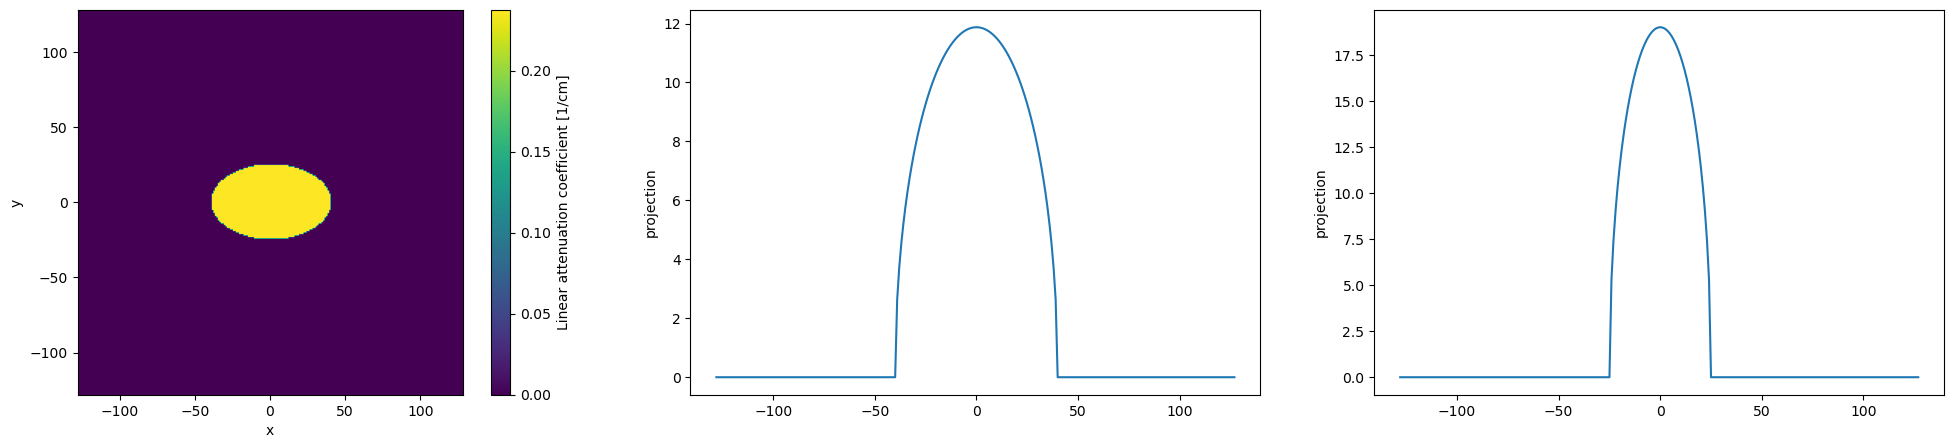

In [64]:
## Plot phantom and projections
plt.close("all")
fig1, axes1 = plt.subplots(1, 3, figsize=(25, 5))
artist = axes1[0].imshow(image.m_as("1/cm"), origin="lower", extent=matrix_extent)
fig1.colorbar(artist, ax=axes1[0], label="Linear attenuation coefficient [1/cm]")

## Plot projections
axes1[1].plot(np.arange(-np.fix(matrix[0]/2), np.fix(matrix[0]/2)), projections[0])
axes1[2].plot(np.arange(-np.fix(matrix[0]/2), np.fix(matrix[0]/2)), projections[1])

# Format axes
axes1[0].set_xlabel("x"), axes1[0].set_ylabel("y");
axes1[1].set_xlabel(""), axes1[1].set_ylabel("projection");
axes1[2].set_xlabel(""), axes1[2].set_ylabel("projection");

## Section 3 - Digital Subtraction Angiography
In the following you are asked to compose a more complex phantom resembling a simplified human thorax including the chest wall, arms, aorta and heart. Using this phantom simulate the digital subtraction angiography (DSA) procedure which includes a pre- and a post-contrast injection projection.

![Figure 3](figure3.png)

#### Task 3.1 
> Compose the thorax phantom by adding all necessary ellipses using the corresponding attenuation coefficients for 50 keV. Consider that line integrals are additive. Accordingly, to generate the lung spaces on top of the thorax (muscle), the difference of linear attenuation coefficients of muscle and lung needs to be assigned to the lung space. Duplicate the phantom for attenuation coefficients at 150 keV!

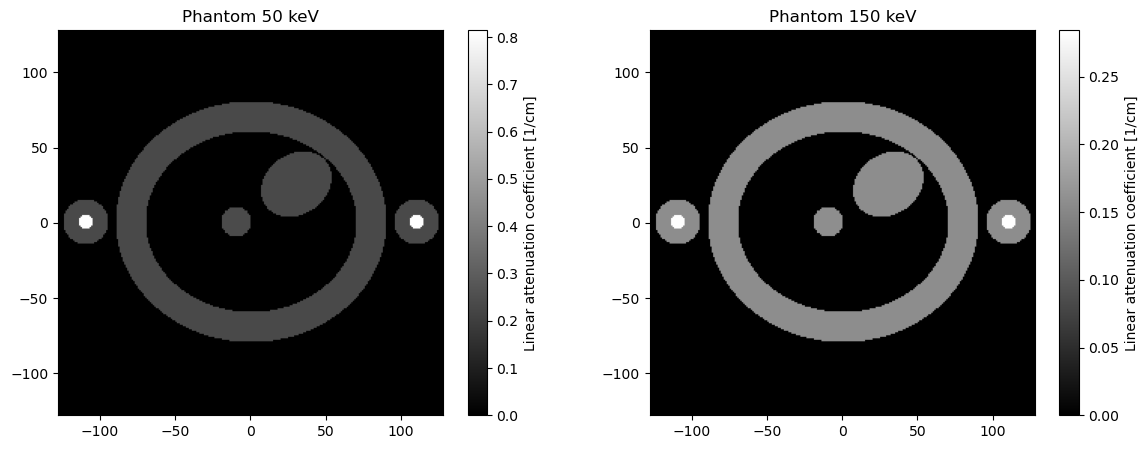

In [65]:
# TASK: Define thorax phantom (50 keV)
lin_dict = lin_attenuation_coeffs_50kev
phantom_50keV = [
SimpleNamespace(x0=0, y0=0, a=90, b=80, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=0, y0=0, a=70, b=60, theta=0, mue=lin_dict["lung"] - lin_dict["muscle"]),
SimpleNamespace(x0=110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
SimpleNamespace(x0=-110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=-110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
SimpleNamespace(x0=-10, y0=0, a=10, b=10, theta=0, mue=lin_dict["blood"] - lin_dict["lung"]),
SimpleNamespace(x0=30, y0=25, a=25, b=20, theta=35, mue=lin_dict["muscle"] - lin_dict["lung"]),
]
# TASK: Define thorax phantom (150 keV)
lin_dict = lin_attenuation_coeffs_150kev
phantom_150keV = [
SimpleNamespace(x0=0, y0=0, a=90, b=80, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=0, y0=0, a=70, b=60, theta=0, mue=lin_dict["lung"] - lin_dict["muscle"]),
SimpleNamespace(x0=110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
SimpleNamespace(x0=-110, y0=0, a=15, b=15, theta=0, mue=lin_dict["muscle"]),
SimpleNamespace(x0=-110, y0=0, a=5, b=5, theta=0, mue=lin_dict["bone"] - lin_dict["muscle"]),
SimpleNamespace(x0=-10, y0=0, a=10, b=10, theta=0, mue=lin_dict["blood"] - lin_dict["lung"]),
SimpleNamespace(x0=30, y0=25, a=25, b=20, theta=35, mue=lin_dict["muscle"] - lin_dict["lung"]),
]

# TASK: Calculate discretized phantoms
discrete_phantom_50keV = calculate_discrete_phantom(matrix, phantom_50keV)
discrete_phantom_150keV = calculate_discrete_phantom(matrix, phantom_150keV)

# Display phantoms
fig4, axes4 = plt.subplots(1, 2, figsize=(14, 5))
artist1 = axes4[0].imshow(discrete_phantom_50keV.m_as("1/cm"), origin="lower", cmap="gray", extent=matrix_extent)
fig1.colorbar(artist1, ax=axes4[0], label="Linear attenuation coefficient [1/cm]")
artist2 = axes4[1].imshow(discrete_phantom_150keV.m_as("1/cm"), origin="lower", cmap="gray", extent=matrix_extent)
fig1.colorbar(artist2, ax=axes4[1], label="Linear attenuation coefficient [1/cm]")
axes4[0].set_title("Phantom 50 keV"), axes4[1].set_title("Phantom 150 keV");

#### Task 3.2
> Compute projections for anode voltages of 50 versus 150 keV. How does contrast between bone
and muscle change and why?

*Type your answer here:*
> Since the probability of the photoelectric interaction is $~\rho*Z^3/E^3$, attenuation difference is bigger for low energy.

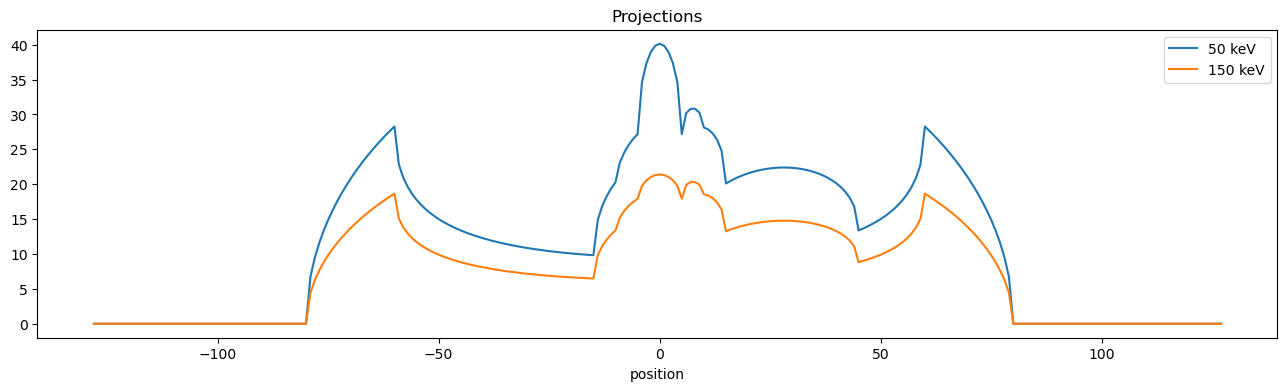

In [66]:
# Define number of detector bins
detector_bins = 256

# Define projection angles
projection_angles = [90]

# TASK: Calculate projections
projections_50 = calculate_line_integrals(detector_bins, projection_angles, phantom_50keV)
projections_150 = calculate_line_integrals(detector_bins, projection_angles, phantom_150keV)

# Display projections
plt.close("all")
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 4))

axes5.plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)), projections_50.T, label="50 keV")
axes5.plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)), projections_150.T, label="150 keV")
axes5.legend(), axes5.set_title("Projections"), axes5.set_xlabel("position");

#### Task 3.3
> Compute horizontal, vertical and angulated projections for 50 keV and 150 keV. Why is the aorta (blood) not seen well?

*Type your answer here*
> Difference of linear attenuation coefficient of aorta and lung tissue is small.

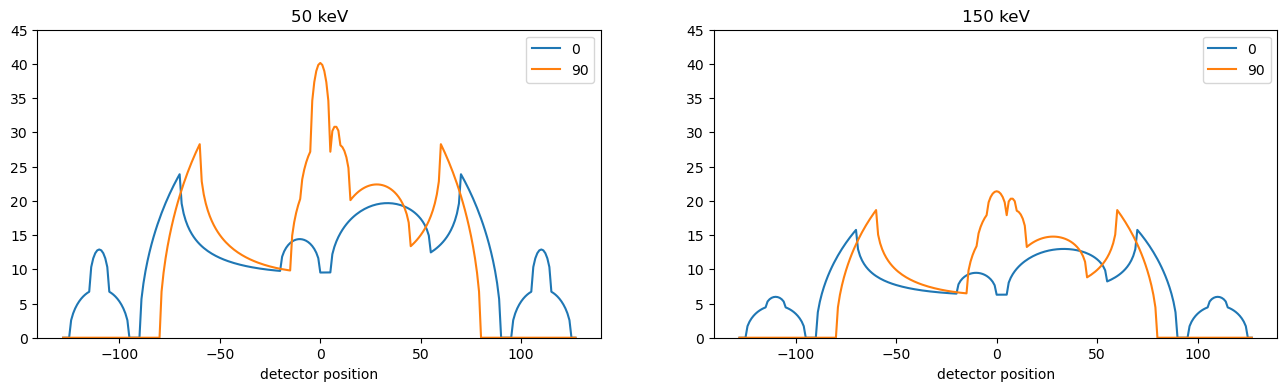

In [67]:
# Define number of detector bins
detector_bins = 256

# Define projection angles
projection_angles = [0, 90]

# TASK: Calculate projections
projections_50=calculate_line_integrals(detector_bins,projection_angles,phantom_50keV)
projections_150=calculate_line_integrals(detector_bins,projection_angles,phantom_150keV)

# Display projections
plt.close("all")
fig5, axes5 = plt.subplots(1, 2, figsize=(16, 4))

axes5[0].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)), projections_50.T, label=[str(p) for p in projection_angles])
axes5[1].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)), projections_150.T, label=[str(p) for p in projection_angles])
axes5[0].legend(), axes5[1].legend(), axes5[0].set_title("50 keV"), axes5[1].set_title("150 keV");
axes5[0].set_xlabel("detector position"), axes5[1].set_xlabel("detector position");
axes5[0].set_ylim([0, 45]), axes5[1].set_ylim([0, 45]);

#### Task 3.4
> Derive general equation of blood contrast based on Beer-Lamberts law for the DSA principle.

*Type your answer here*:
> $I = I_0*e^{-( \mu_{contrastagent} - \mu_{blood})*d)}$ 

#### Task 3.5
> Implement DSA principle using two measurements of the same projection - one without and one upon intravascular administration of an iodine contrast agent.    
> *Hint*: (mass attenuation coefficient of blood with iodine contrast agent is doubled relative to the value of blood only).

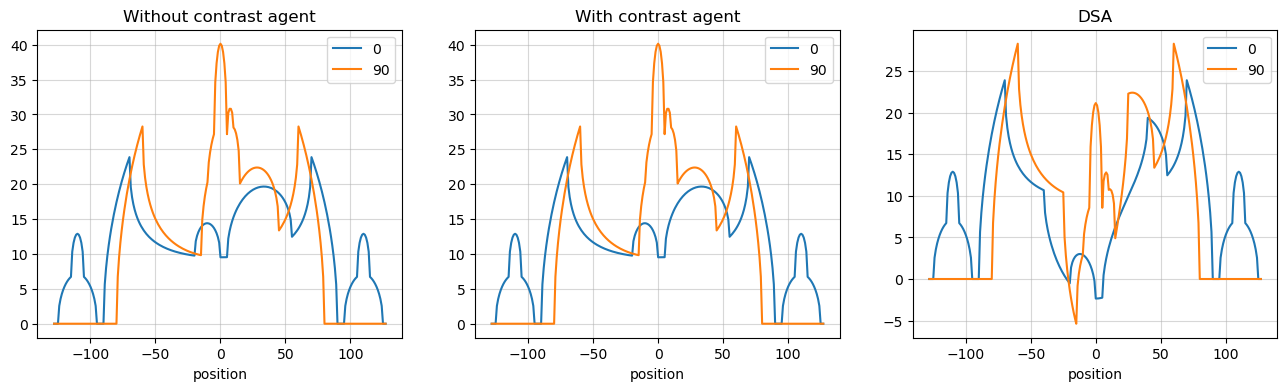

In [70]:
# Define number of detector bins
detector_bins = 256

# Define projection angles
projection_angles = [0,90]

# TASK: Define phantom prior to contrast agent administration (copy from Task 3.1)
lin_dict = lin_attenuation_coeffs_50kev

phantom_50kev = [
SimpleNamespace(x0=0,y0=0,a=90,b=80,theta=0,mue=lin_dict["muscle"]),
SimpleNamespace(x0=0,y0=0,a=70,b=60,theta=0,mue=lin_dict["lung"]-lin_dict["muscle"]),
SimpleNamespace(x0=110,y0=0,a=15,b=15,theta=0,mue=lin_dict["muscle"]),
SimpleNamespace(x0=110,y0=0,a=5,b=5,theta=0,mue=lin_dict["bone"]-lin_dict["muscle"]),
SimpleNamespace(x0=-110,y0=0,a=15,b=15,theta=0,mue=lin_dict["muscle"]),
SimpleNamespace(x0=-110,y0=0,a=5,b=5,theta=0,mue=lin_dict["bone"]-lin_dict["muscle"]),
SimpleNamespace(x0=-10,y0=0,a=10,b=10,theta=0,mue=lin_dict["blood"]-lin_dict["lung"]),
SimpleNamespace(x0=30,y0=25,a=25,b=20,theta=35,mue=lin_dict["muscle"]-lin_dict["lung"]),
]

# TASK: Calculate projections (pre-contrast)
projections_pre = calculate_line_integrals(detector_bins,projection_angles,phantom_50keV)

# TASK: Update phantom properties after contrast agent administration
phantom_50kev[6].mue = 2*lin_dict["blood"]-lin_dict["lung"]

# TASK: Calculate projections (post-contrast)
projections_post = calculate_line_integrals(detector_bins,projection_angles,phantom_50keV)

# TASK: Calculate DSA 
dsa = projections_post-projections

# Display projections
plt.close("all")
fig6, axes6 = plt.subplots(1, 3, figsize=(16, 4))
x_vals = np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2))

for ax, data in zip(axes6, [projections_pre, projections_post, dsa]):
    ax.plot(x_vals, data.T, label=[str(p) for p in projection_angles])
    ax.legend(), ax.grid(True, alpha=0.5), ax.set_xlabel("position")
    
axes6[0].set_ylim(axes6[1].get_ylim())
axes6[0].set_title("Without contrast agent"), axes6[1].set_title("With contrast agent"), axes6[2].set_title("DSA");

#### Task 3.6 
> Document the DSA result and explain why the vessel contrast has improved?

*Type your answer here:*
> All signal except signal originating from the contrast agent is cancelled out.